## Import functions we'll need

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime
from geopy.distance import vincenty
from matplotlib import ticker
from NFLFunctions import * # custom functions used below
from string import digits
import scipy.optimize as optimization
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load the data from csv

In [2]:
scores = pd.read_csv('/Users/dekedor/Programming/NFLDB/NFL_Data_DataFrame_V1.csv')

## Scoring Over Time

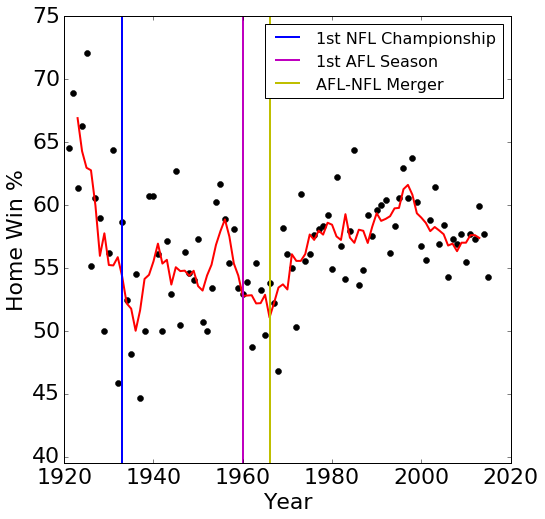

In [3]:
fig = plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
mpl.rcParams.update({'font.size': 22})
home_win_per = 100. * \
np.array([scores[(scores['Season'] == year) & (scores['ScoreDiff'] > 0)]['ScoreDiff'].count()/\
 scores[scores['Season'] == year]['ScoreDiff'].count() for year in np.arange(1921, 2016)])
plot(np.arange(1921, 2016), home_win_per, 'ko')
ave_win = 5
win_plus_minus = (ave_win - 1)//2
win_range = np.arange(1921 + win_plus_minus, 2016 - win_plus_minus)
ave_home_win_per = 100. * \
np.array([scores[(scores['Season'] >= year - win_plus_minus) & \
        (scores['Season'] <= year + win_plus_minus) & (scores['ScoreDiff'] > 0)]['ScoreDiff'].count()/\
 scores[(scores['Season'] >= year - win_plus_minus) & \
        (scores['Season'] <= year + win_plus_minus)]['ScoreDiff'].count() for year in win_range])
plt.plot(win_range, ave_home_win_per, 'r-', linewidth=2)
y_range = np.linspace(39.5, 75, 100)
plt.plot(1933*np.ones_like(y_range), y_range, 'b-', linewidth=2, label='1st NFL Championship')
plt.plot(1960*np.ones_like(y_range), y_range, 'm-', linewidth=2, label='1st AFL Season')
plt.plot(1966*np.ones_like(y_range), y_range, 'y-', linewidth=2, label='AFL-NFL Merger')
legend(fontsize=16)
ylim([39.5, 75])
xlabel('Year')
ylabel('Home Win %')

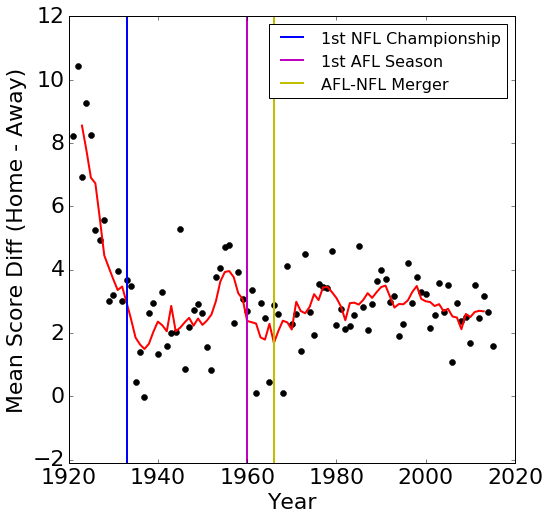

In [4]:
fig = plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
mpl.rcParams.update({'font.size': 22})
diffs = [scores[scores['Season'] == year]['ScoreDiff'].mean() for year in np.arange(1921, 2016)]
plt.plot(np.arange(1921, 2016), diffs, 'ko')
ave_diffs = [scores[(scores['Season'] >= year - win_plus_minus) & \
            (scores['Season'] <= year + win_plus_minus)]['ScoreDiff'].mean() \
             for year in win_range]
plt.plot(win_range, ave_diffs, 'r-', linewidth=2)
y_range = np.linspace(-2.1, 12, 100)
plt.plot(1933*np.ones_like(y_range), y_range, 'b-', linewidth=2, label='1st NFL Championship')
plt.plot(1960*np.ones_like(y_range), y_range, 'm-', linewidth=2, label='1st AFL Season')
plt.plot(1966*np.ones_like(y_range), y_range, 'y-', linewidth=2, label='AFL-NFL Merger')
legend(fontsize=16)
ylim([-2.1, 12])
xlabel('Year')
ylabel('Mean Score Diff (Home - Away)')

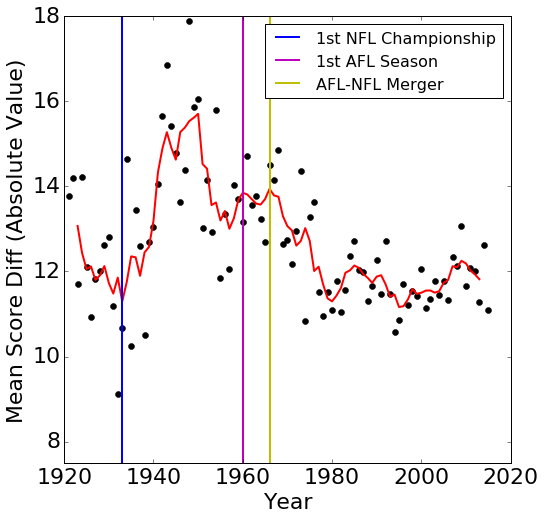

In [5]:
fig = plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
mpl.rcParams.update({'font.size': 22})
scores['Abs(ScoreDiff)'] = np.abs(scores['ScoreDiff'])
diffs = [scores[scores['Season'] == year]['Abs(ScoreDiff)'].mean() for year in np.arange(1921, 2016)]
plt.plot(np.arange(1921, 2016), diffs, 'ko')
ave_diffs = [scores[(scores['Season'] >= year - win_plus_minus) & \
            (scores['Season'] <= year + win_plus_minus)]['Abs(ScoreDiff)'].mean() \
             for year in win_range]
plt.plot(win_range, ave_diffs, 'r-', linewidth=2)
y_range = np.linspace(7.5, 18, 100)
plt.plot(1933*np.ones_like(y_range), y_range, 'b-', linewidth=2, label='1st NFL Championship')
plt.plot(1960*np.ones_like(y_range), y_range, 'm-', linewidth=2, label='1st AFL Season')
plt.plot(1966*np.ones_like(y_range), y_range, 'y-', linewidth=2, label='AFL-NFL Merger')
legend(fontsize=16)
ylim([7.5, 18])
xlabel('Year')
ylabel('Mean Score Diff (Absolute Value)')

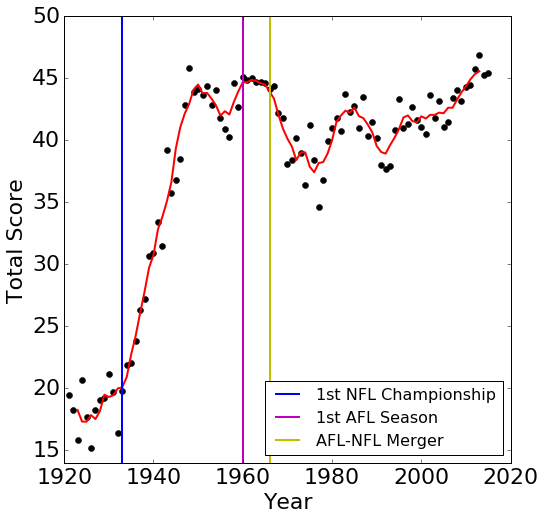

In [6]:
fig = plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
mpl.rcParams.update({'font.size': 22})
scores['TotalScore'] = scores['HomeScore'] + scores['AwayScore']
tots = [scores[scores['Season'] == year]['TotalScore'].mean() for year in np.arange(1921, 2016)]
plt.plot(np.arange(1921, 2016), tots, 'ko')
ave_tots = [scores[(scores['Season'] >= year - win_plus_minus) & \
            (scores['Season'] <= year + win_plus_minus)]['TotalScore'].mean() \
             for year in win_range]
plt.plot(win_range, ave_tots, 'r-', linewidth=2)
y_range = np.linspace(10, 50, 100)
plt.plot(1933*np.ones_like(y_range), y_range, 'b-', linewidth=2, label='1st NFL Championship')
plt.plot(1960*np.ones_like(y_range), y_range, 'm-', linewidth=2, label='1st AFL Season')
plt.plot(1966*np.ones_like(y_range), y_range, 'y-', linewidth=2, label='AFL-NFL Merger')
legend(fontsize=16, loc='lower right')
ylim([14, 50])
xlabel('Year')
ylabel('Total Score')

In [7]:
dists = scores[(scores['TravelDistance'].notnull()) & (scores['Season'] >= 1966) & \
               (scores['Playoffs?'] == False)]['TravelDistance'].values
scores_diffs = scores[scores['TravelDistance'].notnull() & (scores['Season'] >= 1966) & \
                      (scores['Playoffs?'] == False)]['ScoreDiff'].values

## Homefield Advantage Versus Travel Distance

In [8]:
bins = [0, 200, 400, 600, 800, 1000, 1200, 1600, 2000, 3000]
dist_bin = np.digitize(dists, bins)
dist_centers = np.array([np.mean(dists[dist_bin == i]) for i in range(1, len(bins))])
dist_score_diffs = np.array([np.mean(scores_diffs[dist_bin == i]) for i in range(1, len(bins))])
dist_score_diffs_err = np.array([np.std(scores_diffs[dist_bin == i])/np.sqrt(len(scores_diffs[dist_bin == i])) \
                                                                             for i in range(1, len(bins))])

In [9]:
dist_home_win_per = 100. * \
np.array([np.sum(scores_diffs[dist_bin == i] > 0.)/len(scores_diffs[dist_bin == i]) for i in range(1, len(bins))])
games = np.array([len(scores_diffs[dist_bin == i]) for i in range(1, len(bins))])
dist_home_win_per_err = np.sqrt((dist_home_win_per * (100. - dist_home_win_per)) / games)

(50, 62)

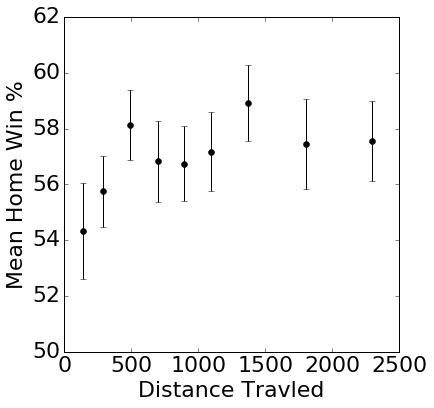

In [10]:
fig = plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
mpl.rcParams.update({'font.size': 22})
plt.errorbar(dist_centers, dist_home_win_per, yerr=dist_home_win_per_err, fmt='ko')
xlabel('Distance Travled')
ylabel('Mean Home Win %')
ylim([50, 62])

(0, 4)

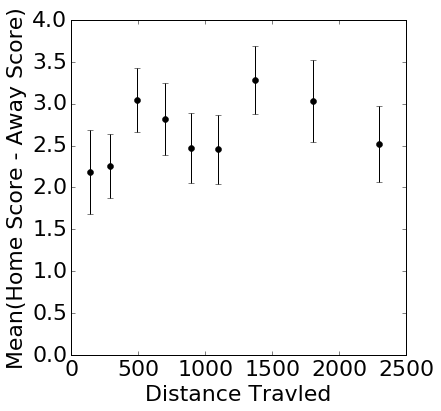

In [11]:
fig = plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
mpl.rcParams.update({'font.size': 22})
plt.errorbar(dist_centers, dist_score_diffs, yerr=dist_score_diffs_err, fmt='ko')
xlabel('Distance Travled')
ylabel('Mean(Home Score - Away Score)')
ylim([0, 4])